In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

import sys
sys.path.insert(0, ".")
from src.settings import modelsettings
from src import preprocess, visualization


Let's load the processed penguins data and preprocess so that we have the floating point data.

In [8]:
filename = ("../.." / modelsettings.processed_dir / "processed.parq").resolve()
p = preprocess.prepare_floats(filename, modelsettings)
p.head(5)


species,variable,value,mean/var,std/var,norm
str,str,f64,f64,f64,f64
"""Adelie""","""cullen""",39.5,44.053395,5.480635,-0.830815
"""Adelie""","""cullen""",40.3,44.053395,5.480635,-0.684847
"""Adelie""","""cullen""",36.7,44.053395,5.480635,-1.341705
"""Adelie""","""cullen""",39.3,44.053395,5.480635,-0.867307
"""Adelie""","""cullen""",38.9,44.053395,5.480635,-0.940292


If we plot the distributions for the species, we can see the overlap

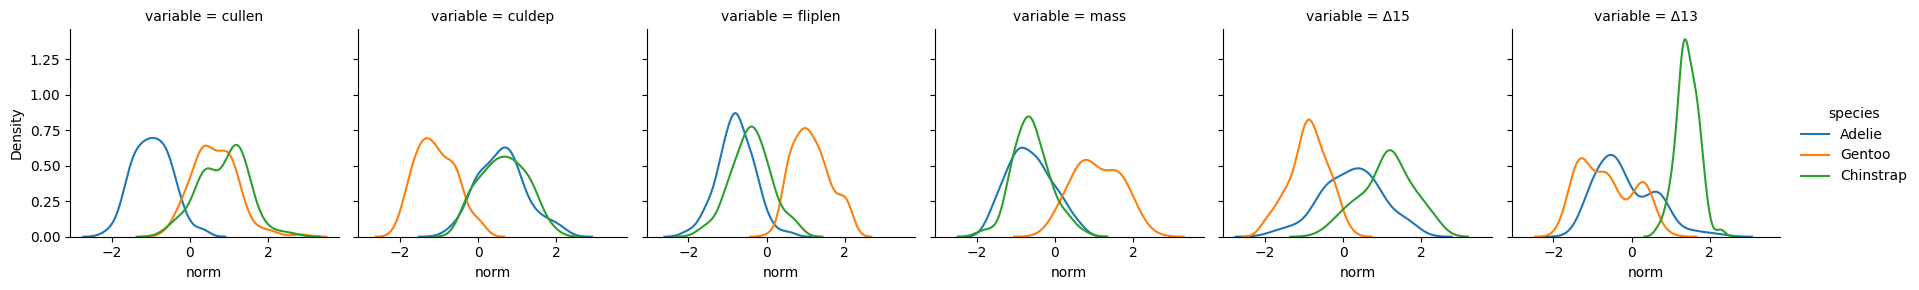

In [9]:
g = sns.FacetGrid(p.to_pandas(), col="variable", hue="species")
g.map_dataframe(sns.kdeplot, x="norm")

g.add_legend()

I hope it is self explanatory that you need more than one variable to split this data.

If you look at "cullen", you can identify "Adelie", but you can't discern between "Gentoo" and "Chinstrap" because they have the same size.

However, if you look at "culdep", we can discern between "Gentoo" and the rest. This means that combining two variables will give you the species!

If you visualize this, it becomes clear:

<AxesSubplot: xlabel='cullen', ylabel='culdep'>

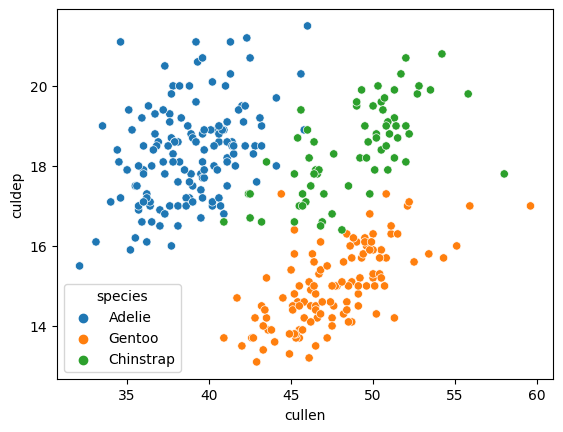

In [10]:
subset = (
    pl.read_parquet(filename)
    .select(
        [
            pl.col(["species", "cullen", "culdep"]),
        ]
    )
    .to_pandas()
)
sns.scatterplot(data=subset, x="cullen", y="culdep", hue="species")


# Modelling with Scikit-learn

Looking at the scatterplot, you can almost see the model!

You will need to split the data at $cullen=42$ and $culdep=16$, sort of.
That will give you the classification into three species.

Can we automate that? Sure, we can, with scikit-learn!

Scikit-learn has great [documentation](https://scikit-learn.org/stable/index.html)

Really, take some time to study it. The quality is very high, and there are lots of examples.

If you look at the homepage, you can read a one-line introduction into classification:

> "Identifying which category an object belongs to."

That sounds like what we want to do. 
First thing we need to do, is to split the variables and the outcome.

In [11]:
y, X = subset["species"], subset[["cullen", "culdep"]]


We will also need to keep a small set apart.

YOu can read more about the background [here](https://scikit-learn.org/stable/modules/cross_validation.html)

The first sentence on that page is:

> Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data.

In it's most basic form, scikit-learn models only require four lines of code:

```
from sklearn import Model
model = Model()
model.fit(X_train, y_train)
model.score(X_test, y_test)
```

You import a model, fit it on the traindata, and test it on the testdata.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png">

Looking at the classification models, there is a lot of choice.
Let's pick the DecisionTreeClassifier

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9384615384615385

So, we get an accuracy of 93%.
That's nice!

Note we only tested on 20% of the data, so your mileage may vary...

We can visualize what the model did (if we have 2 dimensions, which we have)

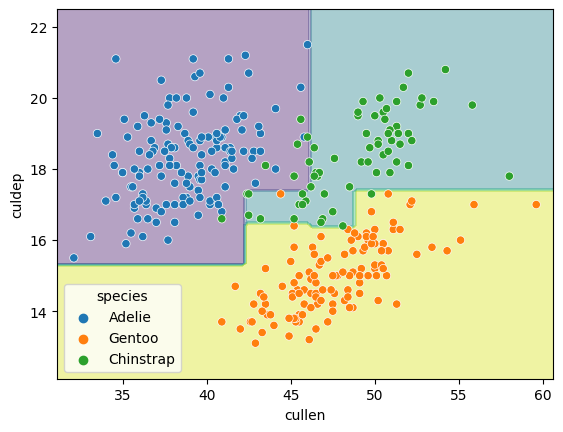

In [28]:
visualization.inspect_model(model, X, y)

0.9384615384615385

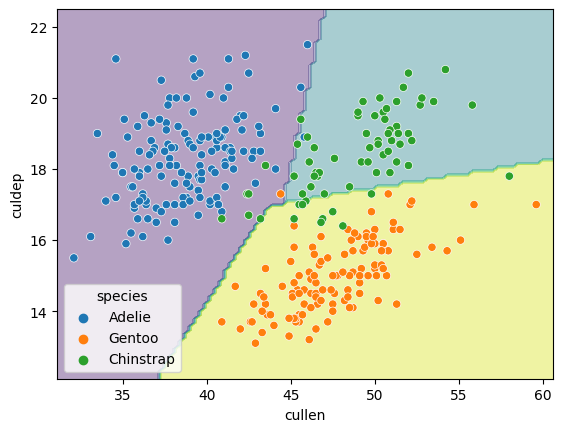

In [24]:
from sklearn.svm import SVC

model = SVC()
visualization.inspect_model(model, X, y)
model.score(X_test, y_test)


Even though both models score 93%, I would still prefer the SVC model.